In [2]:
import subprocess
import pydot
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import time

Код для замера времени исполнения генерации

In [9]:
def measure_execution_time(program, num_vertices, num_trials):
    total_time = 0
    for _ in range(num_trials):
        start_time = time.time()
        subprocess.run([program, str(num_vertices)], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
        end_time = time.time()
        execution_time = end_time - start_time
        total_time += execution_time
    average_time = total_time / num_trials
    return average_time


program_name = "a.exe"
num_vertices = 10000
num_trials = 3
average_execution_time = measure_execution_time(program_name, num_vertices, num_trials)
print(f"Average execution time over {num_trials} trials: {average_execution_time:.6f} seconds")

Average execution time over 3 trials: 7.765182 seconds


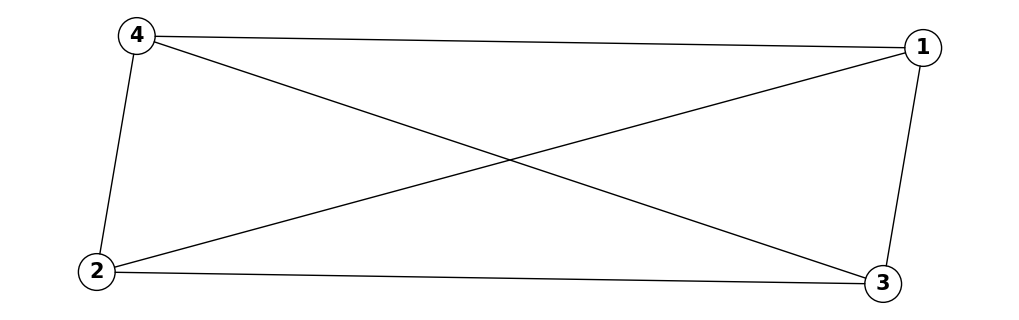

In [136]:
# Компиляция prufer.cpp с помощью g++
#subprocess.run(["g++", "prufer.cpp", "-o", "a.exe"], check=True)

# Запуск a.exe и ожидание завершения
subprocess.run(["a.exe", "4"], check=True)

# Загружаем граф из файла в формате dot с помощью networkx и pydot
G = nx.nx_pydot.read_dot('graph.dot')

# Рисуем дерево
plt.figure(figsize=(10, 3))
nx.draw(G, 
        with_labels=True, 
        node_size=700,
        node_color="none",
        edgecolors="black",
        font_size=15, 
        font_weight='bold', 
        edge_color='black', 
        font_color='black') 
plt.show()

In [ ]:
import subprocess
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np  # Для работы с диапазонами
import math  # Для использования логарифма

# Функция для чтения рёбер из файла DOT
def read_dot_edges(dot_file):
    edges = []
    with open(dot_file, 'r') as f:
        for line in f:
            # Ищем строки вида "x -- y;"
            if '--' in line:
                # Убираем лишние символы и разделяем по символу --
                parts = line.strip().strip(';').split(' -- ')
                if len(parts) == 2:
                    edges.append(tuple(map(int, parts)))
    return edges

# Инициализируем список рёбер
edges = []

# Считаем степени вершин
degree_count = defaultdict(int)
n = 10000

trials = 1000
# Процесс генерации графов и подсчета степеней
for i in range(trials):
    subprocess.run(["a.exe", f"{n}"], check=True)
    edges = read_dot_edges('graph.dot')
    # Подсчитываем степени для каждой вершины
    for u, v in edges:
        degree_count[u] += 1
        degree_count[v] += 1

# Нормировка
for vertex in range(1, n + 1):
    degree_count[vertex] //= trials

# Список степеней вершин
degrees = [degree_count[vertex] for vertex in range(1, n + 1)]

# Используем логафримическую оценку
num_bins = math.ceil(math.log2(len(degrees)) + 1)
bin_range = np.arange(min(degrees) - 0.5, max(degrees) + 1.5, 1)

# Строим гистограмму степеней с нужным диапазоном бинов
plt.hist(degrees, bins=num_bins, edgecolor='black', alpha=0.7)
plt.title('Гистограмма степеней вершин')
plt.xlabel('Степень вершины')
plt.ylabel('Частота')
plt.show()